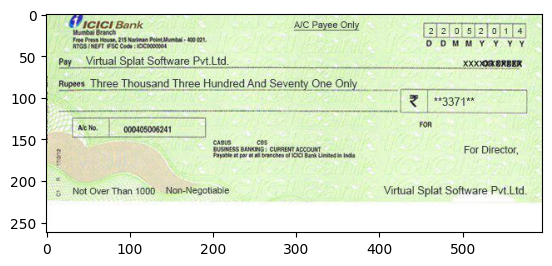

In [5]:
from skimage import io, img_as_float
import matplotlib.pyplot as plt
import imutils
import cv2
import numpy as np

image = img_as_float(cv2.imread('check8.jpg'))
img2 = cv2.imread('check8.jpg')
white = np.array([0.7,0.7,0.7])
mask=np.abs(image - white).sum(axis=2)<0.9
coords=np.array(np.nonzero(~mask))
top_left=np.min(coords,axis=1)
bottom_right=np.max(coords,axis=1)

#out=image[top_left[0]:bottom_right[0],
#        top_left[1]:bottom_right[1]]

out=img2[top_left[0]:bottom_right[0],
        top_left[1]:bottom_right[1]]

#cv2.imwrite('check4.jpg',out)

plt.imshow(out)
plt.show()

image = out

In [10]:
from imutils.object_detection import non_max_suppression
import numpy as np
import pytesseract
import cv2
import time
import os

image = cv2.imread('check8.jpg')
orig = image.copy()
orig1 = image.copy()
(H, W) = image.shape[:2]
(newW, newH) = (320, 320)
rW = W / float(newW)
rH = H / float(newH)
image = cv2.resize(image, (newW, newH))
(H, W) = image.shape[:2]

In [11]:
cv2.imshow('Test image',orig)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [12]:
net = cv2.dnn.readNet('frozen_east_text_detection.pb')
blob = cv2.dnn.blobFromImage(image, 1.0, (newW,newH),(123.68, 116.78, 103.94), swapRB=True, crop=False)
layerNames = ["feature_fusion/Conv_7/Sigmoid","feature_fusion/concat_3"]
start = time.time()
net.setInput(blob)
(scores, geometry) = net.forward(layerNames)
end = time.time()
print("[INFO] text detection took {:.6f} seconds".format(end - start))

[INFO] text detection took 0.129628 seconds


In [13]:
(numRows, numCols) = scores.shape[2:4]
rects = []
confidences = []
for y in range(0, numRows):
    scoresData = scores[0, 0, y]
    xData0 = geometry[0, 0, y]
    xData1 = geometry[0, 1, y]
    xData2 = geometry[0, 2, y]
    xData3 = geometry[0, 3, y]
    anglesData = geometry[0, 4, y]
    for x in range(0, numCols):
        if scoresData[x] < 0.5:
                continue

        (offsetX, offsetY) = (x * 4.0, y * 4.0)

        angle = anglesData[x]
        cos = np.cos(angle)
        sin = np.sin(angle)

        h = xData0[x] + xData2[x]
        w = xData1[x] + xData3[x]

        endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
        endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
        startX = int(endX - w)
        startY = int(endY - h)

        rects.append((startX, startY, endX, endY))
        confidences.append(scoresData[x])

In [15]:
boxes = non_max_suppression(np.array(rects), probs=confidences)
results = []

for (startX, startY, endX, endY) in boxes:
# scale the bounding box coordinates based on the respective
# ratios
    startX = int(startX * rW)-5
    startY = int(startY * rH)-5
    #endX = int(endX * rW)
    #endY = int(endY * rH)
    endX = int(endX * rW)+5
    endY = int(endY * rH)+5
    dX = int((endX - startX) * 0.0)
    dY = int((endY - startY) * 0.0)
    startX = max(0, startX - dX)
    startY = max(0, startY - dY)
    roi = orig[startY:endY, startX:endX]
    config = ("-l eng --oem 1 --psm 7")
    pytesseract.pytesseract.tesseract_cmd = 'tesseract'
    text = pytesseract.image_to_string(roi, config=config)
    results.append(((startX, startY, endX, endY), text))
    config = ("-l eng --oem 1 --psm 7")
    text = pytesseract.image_to_string(roi, config=config)
    results.append(((startX, startY, endX, endY), text))
results = sorted(results, key=lambda r:r[0][1])
results = list(dict.fromkeys(results))
print(results)

[((26, 6, 128, 34), 'icici Bank\n'), ((293, 11, 359, 33), 'AIC Payee ¢\n'), ((338, 12, 387, 34), 'ee Only\n'), ((445, 17, 530, 41), '2] 2) 0] 5]2\n'), ((100, 28, 183, 50), 'ras Pelt er 10\n'), ((452, 31, 580, 55), '‘DomMmY Y YY\n'), ((169, 52, 226, 76), '> Pyt Lid.\n'), ((118, 53, 175, 76), 'Software\n'), ((40, 53, 81, 77), 'Virtuz\n'), ((86, 54, 126, 78), 'Splat §\n'), ((497, 58, 584, 78), 'OQOOORBREER\n'), ((143, 78, 192, 105), 'i Three\n'), ((184, 79, 265, 103), '. Hundred And\n'), ((278, 80, 355, 103), 'eventy One C\n'), ((85, 80, 145, 105), ': Thousane\n'), ((49, 80, 96, 104), 'Three 1\n'), ((336, 82, 383, 104), 'e Only\n'), ((6, 84, 50, 106), '‘Rupees\n'), ((460, 102, 526, 126), '"3371"\n'), ((23, 133, 70, 157), ''), ((86, 137, 153, 156), '900405006241\n'), ((501, 160, 573, 183), 'For Director,\n'), ((278, 167, 368, 187), 're Hoel Lined nd\n'), ((199, 167, 273, 188), ''), ((471, 209, 546, 231), 't Software P\n'), ((518, 209, 584, 233), 're Pvt Ltd.\n'), ((25, 210, 81, 231), '‘Not

In [ ]:
boxes = non_max_suppression(np.array(rects), probs=confidences)

# loop over the bounding boxes
for (startX, startY, endX, endY) in boxes:
# scale the bounding box coordinates based on the respective
# ratios
    startX = int(startX * rW)-5
    startY = int(startY * rH)-5
    endX = int(endX * rW)+5
    endY = int(endY * rH)+5
    
    # draw the bounding box on the image
    cv2.rectangle(orig1, (startX, startY), (endX+10, endY+10), (0, 255, 0), 2)

# show the output image
cv2.imshow("Text Detection", orig1)
cv2.waitKey(0)


In [8]:
mmH = 320/78
mmW = 320/202
Y1 = int(mmH*38)
Y2 = int(mmH*50)
X1 = int(mmW*10)
X2 = int(mmW*70)
startX = int(X1 * rW)
startY = int(Y1 * rH)
endX = int(X2 * rW)
endY = int(Y2 * rH)
account = [startX,startY,endX,endY]
print(account)

[28, 132, 206, 175]


In [9]:
mmH = 320/78
mmW = 320/202
Y1 = int(mmH*25)
Y2 = int(mmH*40)
X1 = int(mmW*150)
X2 = int(mmW*200)
startX = int(X1 * rW)
startY = int(Y1 * rH)
endX = int(X2 * rW)
endY = int(Y2 * rH)
rupee = [startX,startY,endX,endY]
print(rupee)

[444, 87, 592, 140]


In [10]:
import re

x1 = rupee[0]
x2 = rupee[2]
y1 = rupee[1]
y2 = rupee[3]

a1 = account[0]
b1 = account[1]
a2 = account[2]
b2 = account[3]


for ((startX, startY, endX, endY), text) in results:
    startX = int(startX)
    startY = int(startY)
    endX = int(endX)
    endY = int(endY)
    if(startX>x1 and startY>y1 and endX<x2 and endY<y2):
        text = re.search(r'\d+',text)
        print("Amount : ",text.group())
    if(startX>a1 and startY>b1 and endX<a2 and endY<b2):
        text = re.search('[0-9]{10,16}',text)
        print("Account : ",text.group())


Amount :  3371
Account :  900405006241


In [18]:
boxes = non_max_suppression(np.array(rects), probs=confidences)

# loop over the bounding boxes
for (startX, startY, endX, endY) in boxes:
# scale the bounding box coordinates based on the respective
# ratios
    startX = int(startX * rW)-5
    startY = int(startY * rH)-5
    endX = int(endX * rW)+5
    endY = int(endY * rH)+5
    
    # draw the bounding box on the image
    cv2.rectangle(orig1, (startX, startY), (endX+10, endY+10), (0, 255, 0), 2)

# show the output image
cv2.imshow("Text Detection", orig1)
cv2.waitKey(0)

-1

In [17]:

x1 = account[0]
x2 = account[2]
y1 = account[1]
y2 = account[3]

temp = cv2.imread('check10.jpg')
cv2.rectangle(temp, (x1, y1), (x2, y2), (0, 255, 0), 2)


# show the output image
cv2.imshow("Text Detection", temp)
cv2.waitKey(0)

-1